# Description of clinical dataset

The studied cohort initially comprised 396 individuals from France and Quebec, drawn from four different cohorts recruited between 2003 and 2023. These individuals were either diagnosed with first-episode psychosis - schizophrenia (SCZ) or bipolar disorder (BD) or identified as having an ultra-high-risk (UHR) status. They were followed up for 12 months to monitor the transition to psychosis, with UHR-C denoting those who converted to psychosis and UHR-NC standing for those who did not.

Only the patients with established phenotype were considered in the following analysis. The patients with unknown outcome were excluded. 

Clinical variables reflect different scales of symptom severity:  
  
- **PANSS** (Positive and Negative Syndrome Scale for Schizophrenia) - Evaluates symptom intensity in schizophrenia through three subscales: positive symptoms (7 items), negative symptoms (7 items), and general psychopathological symptoms (16 items). Each item is scored from 1 to 7, yielding a total score ranging from 30 to 210.
  
- **BPRS** (Brief Psychiatric Rating Scale) - Rapidly assesses major psychiatric symptoms with 18 items scored from 1 to 7, providing an overview of psychiatric symptoms with a total score ranging from 18 to 126.
  
- **SANS** (Scale for the Assessment of Negative Symptoms) - Assesses the severity of positive symptoms in schizophrenia.
  
- **SAPS** (Scale for the Assessment of Positive Symptoms) - Assesses the severity of negative symptoms in schizophrenia.
  
- **YMRS** (Young Mania Rating Scale) - Assesses manic symptoms, particularly during initial episodes of psychosis, with 11 items scored from 0 to 4 (or 8), providing a total score ranging from 0 to 60.

- **MADRS** (Montgomery-Asberg Depression Rating Scale) - Measures the severity of depressive symptoms with 10 items, each scored from 0 to 6, resulting in a total score ranging from 0 to 60.

- **SOFAS** (Social and Occupational Functioning Scale) - Evaluates global functioning in daily life, with scores ranging from 100 (high functioning) to 0 (persistent inability to maintain hygiene).


In [10]:
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal, chi2_contingency
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests
import sys, os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.create_graphs.create_comparison_graph import create_boxplots, parse_descriptors, parse_groups
from scripts.create_graphs.create_pca_graph import generate_pca_plots

sns.set_theme(style="darkgrid")

### Phenotype composition of the dataset

The cohort includes:
- 222 SCZ patients (converters)
- 33 BD patients (converters)
- 47 UHR-C patients (converters)
- 75 UHR-NC patients (non-converters)

In [11]:
df_metadata = pd.read_csv('../data/metadata.csv')

In [12]:
df_metadata["Phenotype_2"].value_counts()

converter        302
non-converter     75
Name: Phenotype_2, dtype: int64

In [13]:
df_metadata["Phenotype_1"].value_counts()


SCZ       222
UHR-NC     75
UHR-C      47
BD         33
Name: Phenotype_1, dtype: int64

### Statistical description of the dataset


The clinical characteristics of the study participants are summarized in the tables below, categorized by phenotypic groups. The table includes the count of participants in each group along with the mean and standard deviation for clinical measures.


In [14]:
df_metadata.groupby('Phenotype_2').describe()

Age                                                     \
               count       mean       std   min   25%   50%   75%   max   
Phenotype_2                                                               
converter      282.0  22.223404  3.715374  16.0  19.0  22.0  25.0  34.0   
non-converter   75.0  21.906667  3.429496  16.0  19.0  22.0  24.0  30.0   

                  IQ              ...   YMRS        MADRS             \
               count        mean  ...    75%   max  count       mean   
Phenotype_2                       ...                                  
converter      286.0   95.548951  ...  16.25  40.0  157.0  17.547771   
non-converter   74.0  106.013514  ...   0.00  18.0   75.0  21.240000   

                                                      
                    std  min   25%   50%   75%   max  
Phenotype_2                                           
converter      9.643282  0.0  10.0  17.0  24.0  44.0  
non-converter  9.843148  1.0  14.0  21.0  30.5  48.0  

[2 rows x 72 columns]

In [15]:
df_metadata.groupby('Phenotype_1').describe()

Age                                                       \
             count       mean       std   min    25%   50%    75%   max   
Phenotype_1                                                               
BD            24.0  22.791667  4.624878  16.0  19.75  22.5  25.25  34.0   
SCZ          211.0  22.516588  3.667549  16.0  20.00  22.0  25.00  32.0   
UHR-C         47.0  20.617021  3.004006  16.0  19.00  20.0  22.00  31.0   
UHR-NC        75.0  21.906667  3.429496  16.0  19.00  22.0  24.00  30.0   

                IQ              ...  YMRS        MADRS                       \
             count        mean  ...   75%   max  count       mean       std   
Phenotype_1                     ...                                           
BD            33.0   95.636364  ...  29.0  40.0    0.0        NaN       NaN   
SCZ          207.0   94.859903  ...  14.0  37.0  110.0  15.554545  9.563488   
UHR-C         46.0   98.586957  ...   1.5  25.0   47.0  22.212766  8.179870   
UHR-NC        74.0  106.013514  ...   0.0  18.0   75.0  21.240000  9.843148   

                                           
             min    25%   50%   75%   max  
Phenotype_1                                
BD           NaN    NaN   NaN   NaN   NaN  
SCZ          0.0   8.25  14.0  22.0  44.0  
UHR-C        3.0  17.50  24.0  28.0  35.0  
UHR-NC       1.0  14.00  21.0  30.5  48.0  

[4 rows x 72 columns]

### Statistical comparison between phenotypical groups on clinical parameters

The H statistic and corresponding p-value from the Kruskal-Wallis test are provided to indicate significant differences between the groups. These measures provide information about the variability within each group and between them.  


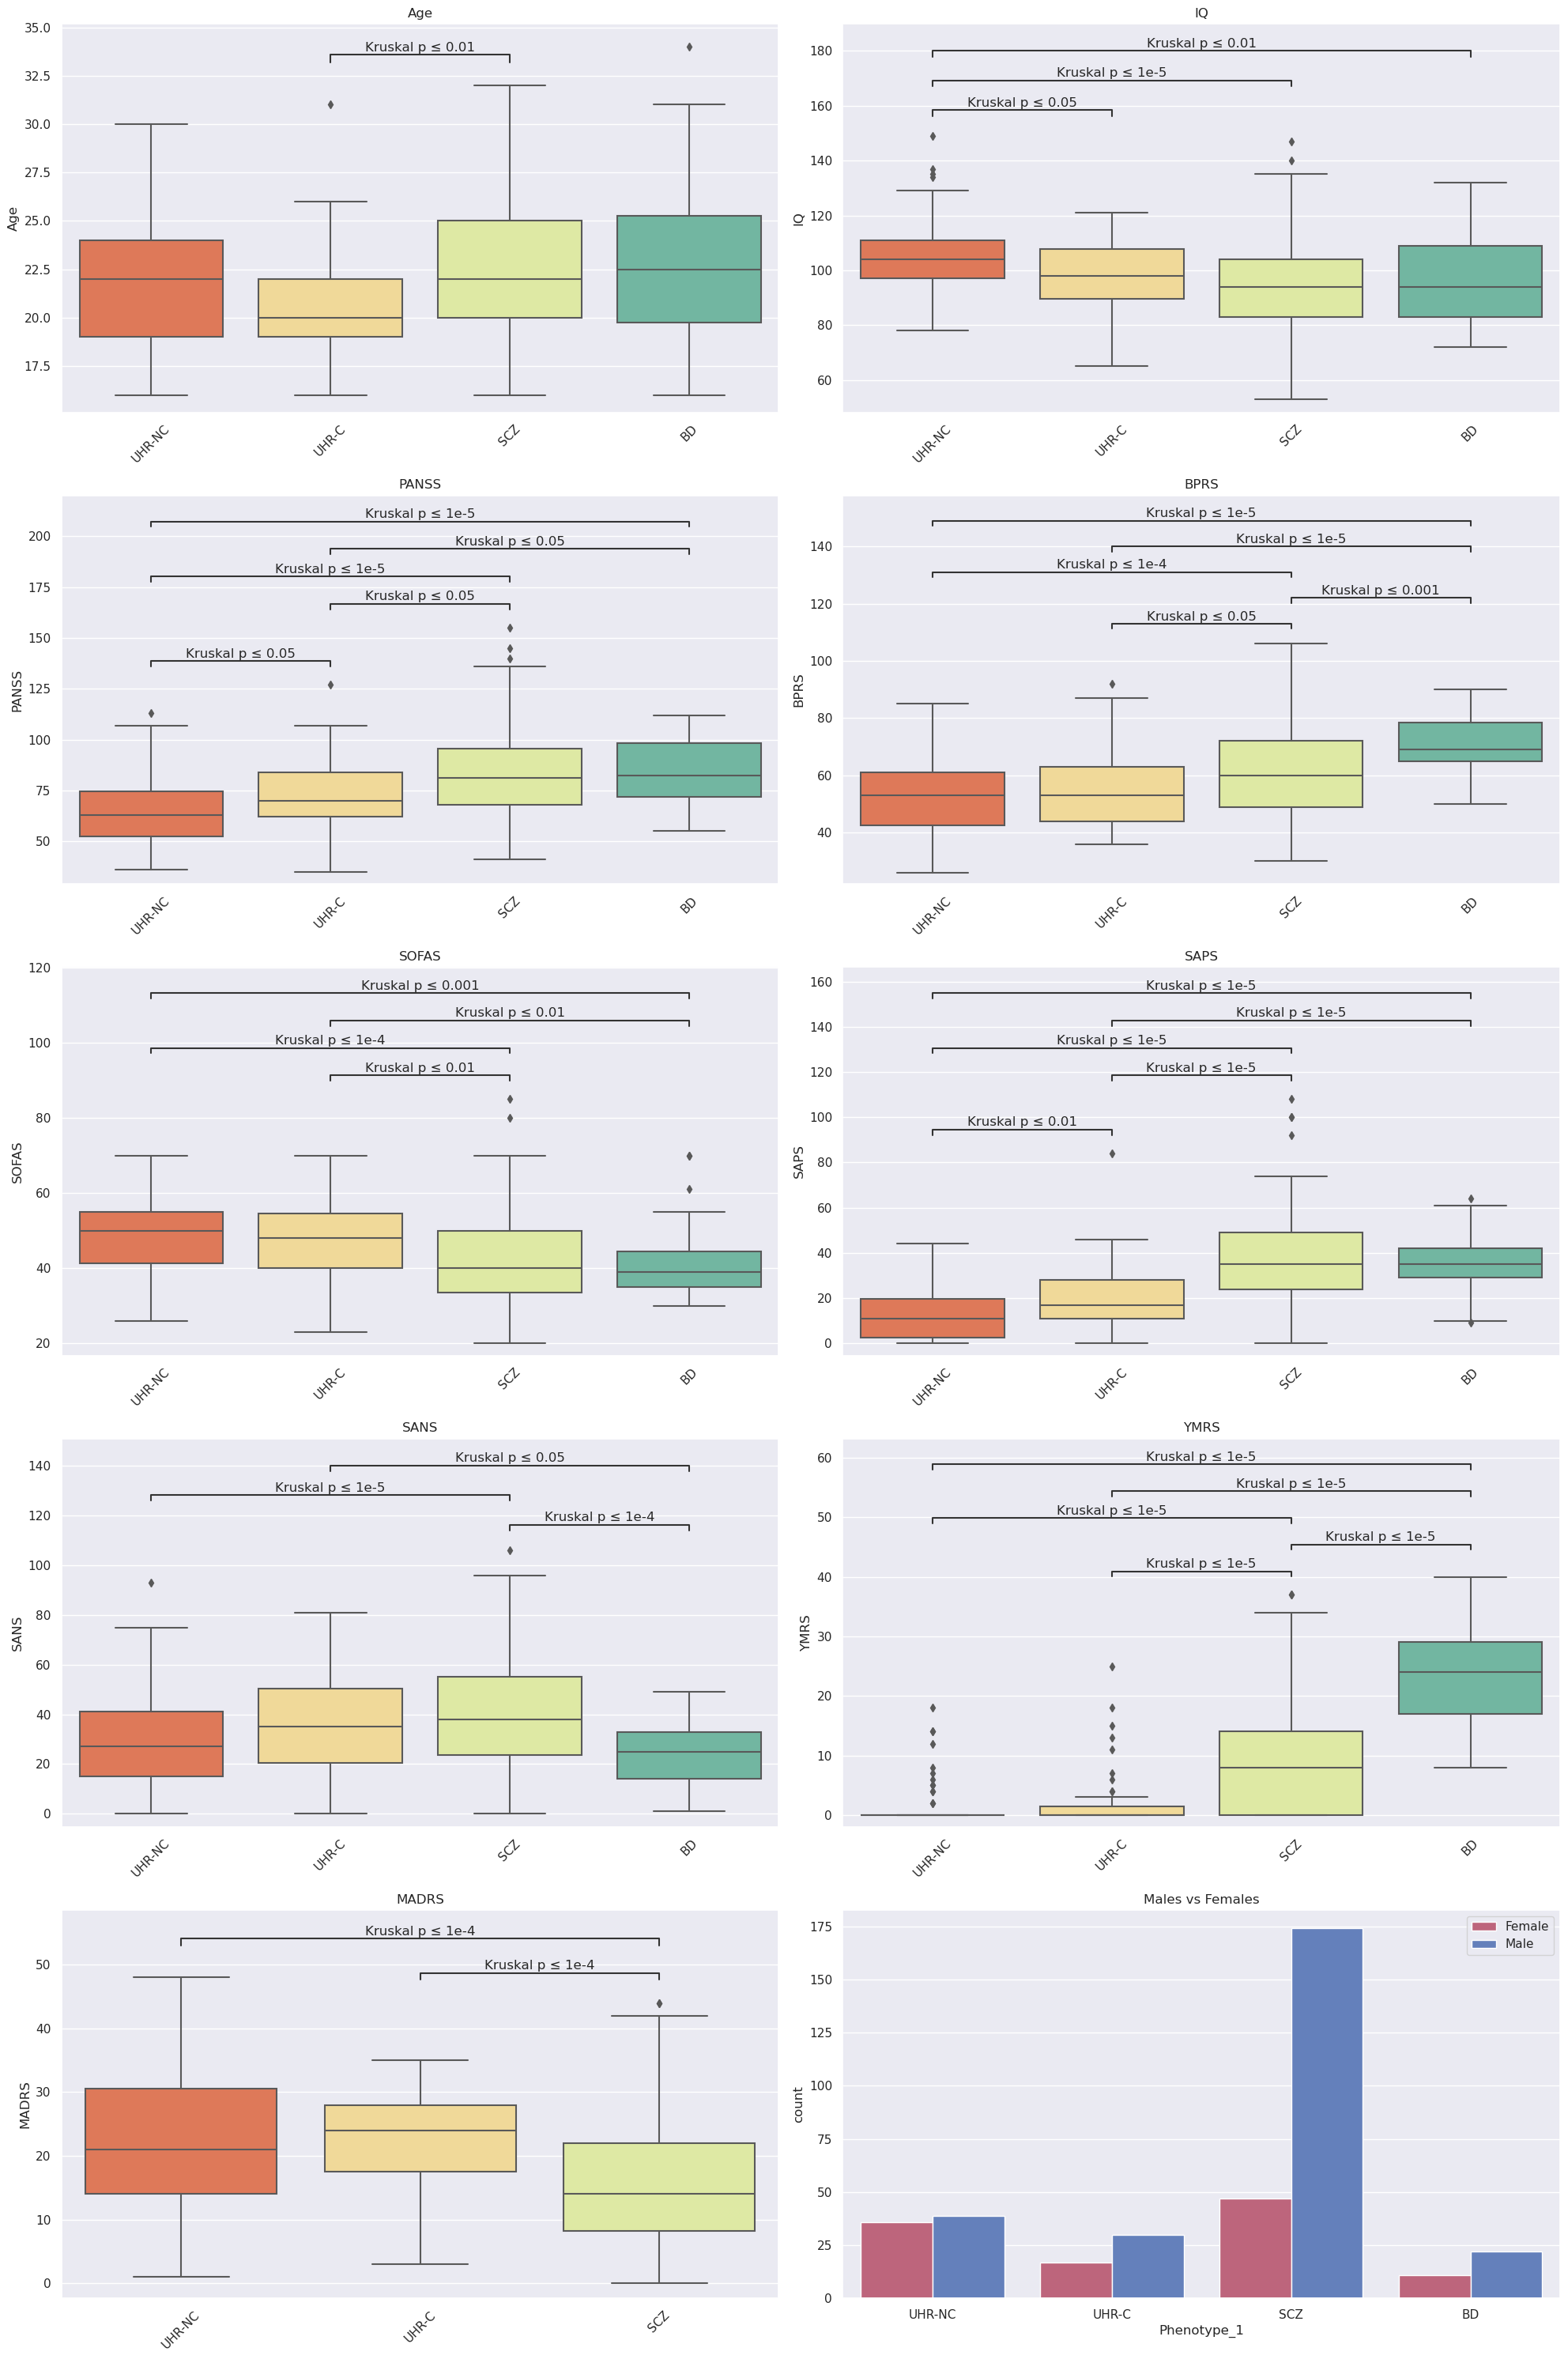

In [16]:
# Define descriptors and groups
descriptors_str = 'Age,IQ,PANSS,BPRS,SOFAS,SAPS,SANS,YMRS'
groups_str = "0:UHR-NC,1:UHR-C,2:SCZ,3:BD"

# Parse the descriptors and group mappings
descriptors = parse_descriptors(descriptors_str)
group_mapping = parse_groups(groups_str)

# Generate the comparison graph with the 
# "../scripts/create_graphs/create_comparison_graph.py" script
create_boxplots(df_metadata, 
                descriptors, 
                group_mapping, 
                '../graphs/metadata_boxplots.png')


All the values are significantly different between the groups. This difference highlights the distinct clinical profiles associated with each diagnostic category.  

The SCZ group shows higher severity in both positive and negative symptoms (SAPS and SANS), aligning with the typical clinical presentation of schizophrenia. The BD group shows high scores on the YMRS, consistent with manic symptoms characteristic of bipolar disorder. The UHR-C and UHR-NC groups display intermediate scores on many measures, suggesting varying degrees of symptom severity and functional impairment.

These differences indicate that the phenotypic groups initially diagnosed by psychiatrists are somewhat accurate, as the measurements differ significantly between the groups.

# PCA analysis of clinical dataset

In [17]:
# MADRS column is not present for BD group
df_metadata = df_metadata.drop(columns=['ID', 'MADRS'])

# Map the categorical variables to numerical values for the PCA
df_metadata["Sex"] = df_metadata["Sex"].map({"Female": 0, "Male": 1})

# Set the categorical variables to category type
df_metadata['Phenotype_1'] = df_metadata['Phenotype_1'].astype('category')
df_metadata['Phenotype_2'] = df_metadata['Phenotype_2'].astype('category')

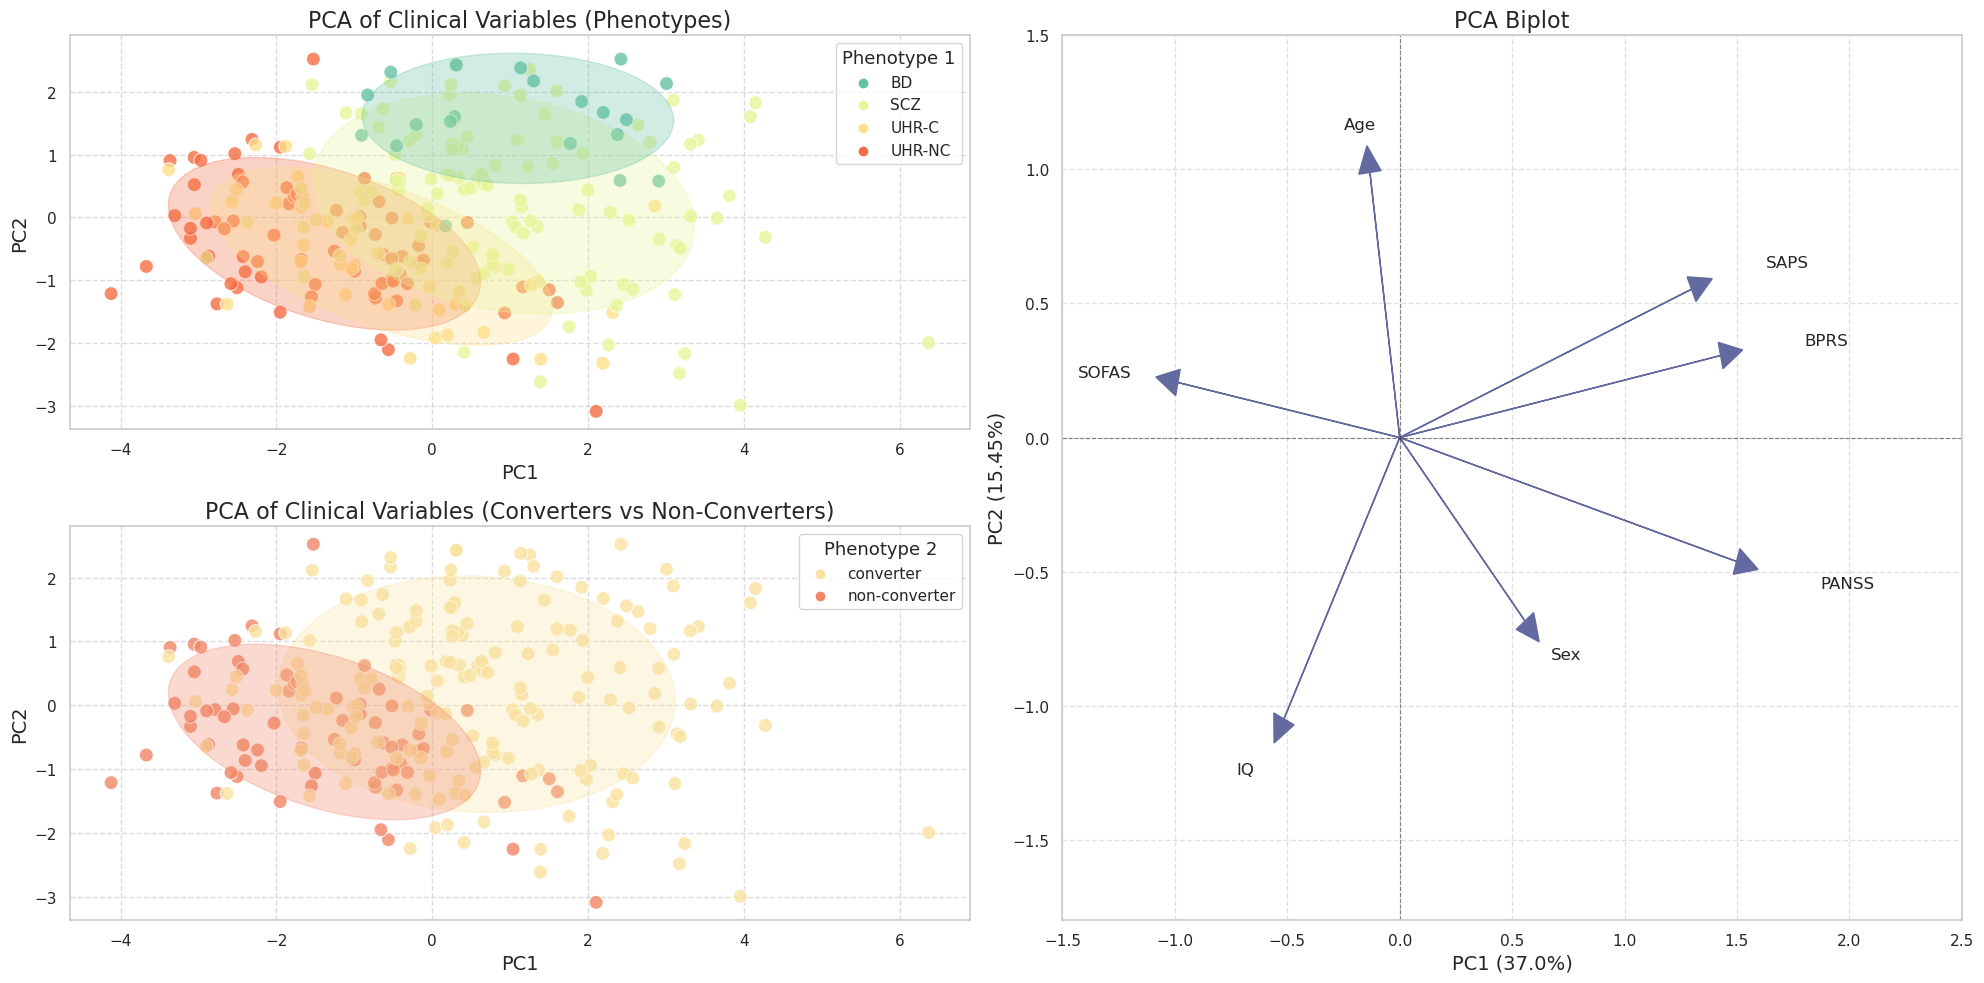

In [18]:
# Specify the columns for phenotypes
phenotype_column = 'Phenotype_1'
converter_column = 'Phenotype_2'

# Specify the output file path for saving the plot
output_file = '../graphs/pca_biplots.png'

# Generate and save the PCA plots
generate_pca_plots(df_metadata, phenotype_column, converter_column, output_file)

The Principal Component Analysis (PCA) of clinical variables reveals distinct clustering among different phenotypic groups, particularly for BD. However, the high heterogeneity within the SCZ group results in greater intra-group diversity compared to inter-group differences. UHR-C and UHR-NC exhibit significant overlap, though converters form a less compact cluster that aligns with diverse profiles of SCZ patients, suggesting similar clinical profiles based on the selected variables. This similarity may be attributed to their higher IQ and lower YMRS scores, significantly contributing to PC2. The BD cluster is primarily defined by YMRS, which is expected due to the prevalence of manic symptoms in BD patients. Additionally, certain variables, such as BPRS and SAPS, show a correlation, reflecting their real-world relationship since BPRS assesses schizophrenic symptoms, including positive symptoms.